# Import files

In [1]:
from zope.interface.common.interfaces import IKeyboardInterrupt

from Strats.PairTradingStrat import *
from statsmodels.tsa.stattools import coint
from itertools import combinations

import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
tickers = [i["symbol"] for i in data]

In [ ]:
coint_pairs = get_coint_pairs(tickers, max_pairs=300, interval = '1d', start_date="2023-01-01", end_date="2023-12-31")

  0%|          | 19/4900015 [00:09<764:28:41,  1.78it/s]

In [4]:
with open('Strats/pairs/saved_pairs.pkl', 'rb') as f:
    coint_pairs = pickle.load(f)


In [5]:
class pair_trading:
    def __init__(self,x_data,y_data,lookback=None,ZSCORE_ENTRY=None):
        self.x_data = x_data
        self.y_data = y_data
        self.lookback = None
        self.ZSCORE_ENTRY = ZSCORE_ENTRY
        self.spread = None
        self.z_scores = None
        self.positions = None
        self.beta = None # beta

    def compute_spread(self,lookback=None):
        x = self.x_data.iloc[:lookback]
        y = self.y_data.iloc[:lookback]

        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        self.beta = model.params[1]
        intercept = model.params[0]
        self.spread = y - (intercept + self.beta*x)

        return self.spread

    def compute_z_score(self, rolling_window=None):
        rolling_mean = self.spread.rolling(window=rolling_window).mean()
        rolling_std = self.spread.rolling(window=rolling_window).std()
        self.z_scores = (self.spread - rolling_mean) / rolling_std
        return self.z_scores

    def generate_signals(self):
        df = pd.DataFrame({"z_scores":self.z_scores})
        df["z_signal"] = np.nan
        df.loc[df.z_scores<-self.ZSCORE_ENTRY, "z_signal"] =  1
        df.loc[df.z_scores>+self.ZSCORE_ENTRY, "z_signal"] =  -1

        df['positions'] = df.z_signal
        df.loc[(df.z_scores.shift(1)*df.z_scores)<0,"positions"] = 0
        df["positions"] = df['positions'].ffill()
        df["BUY_or_SELL"] = df['positions'].fillna(0).diff().shift(1)
        return df

    def plot_signals(self, df):
        fig, axs = plt.subplots(2,1, figsize=(15,9), sharex=True)
        axs[0].plot(df.z_scores, label="Z-score")
        axs[0].axhline(0,color='red')
        axs[0].set_ylabel("Z Scores")
        axs[0].set_xlabel("Date")
        axs[0].legend()
        axs[0].grid(True)
        axs[0].plot(df.loc[df["BUY_or_SELL"] == -1].index, df.z_scores[df["BUY_or_SELL"] == -1], color='r', marker="v", linestyle='')
        axs[0].plot(df.loc[df["BUY_or_SELL"] == +1].index, df.z_scores[df["BUY_or_SELL"] == +1], color='g', marker="^", linestyle='')

        axs[1].plot(self.x_data, label="Asset x")
        axs[1].plot(self.y_data, label="Asset y")
        axs[1].legend()
        axs[1].grid(True)
        plt.show()

    def computePnL(self,df): #have not account for capital
        df["x_pnl"] = self.x_data*df["BUY_or_SELL"]*self.beta
        df["y_pnl"] = self.y_data*-df["BUY_or_SELL"]
        df['cumulative_pnl'] = (df['x_pnl'] + df['y_pnl']).cumsum()
        return df

In [6]:
test_pair = coint_pairs[10]
print(test_pair)

('ETHBTC', 'PAXGUSDT')


In [7]:
symbol_manager = BinanceSymbolManager()
# Add symbols
print(symbol_manager.add_symbol(test_pair[0]))  # Success
print(symbol_manager.add_symbol(test_pair[1]))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="1d",
        start_date="2023-01-01",
        end_date="2023-12-31"
    )

pair_portfolio

'ETHBTC' added successfully.
'PAXGUSDT' added successfully.


,timestamp,ETHBTC,PAXGUSDT
0,2023-01-01,0.072238,1824.00
1,2023-01-02,0.072814,1823.00
2,2023-01-03,0.072840,1841.00
3,2023-01-04,0.074581,1852.00
4,2023-01-05,0.074336,1835.00
...,...,...,...
886,2025-06-05,0.023780,3381.55
887,2025-06-06,0.023750,3333.88
888,2025-06-07,0.023910,3332.40
889,2025-06-08,0.023740,3340.75


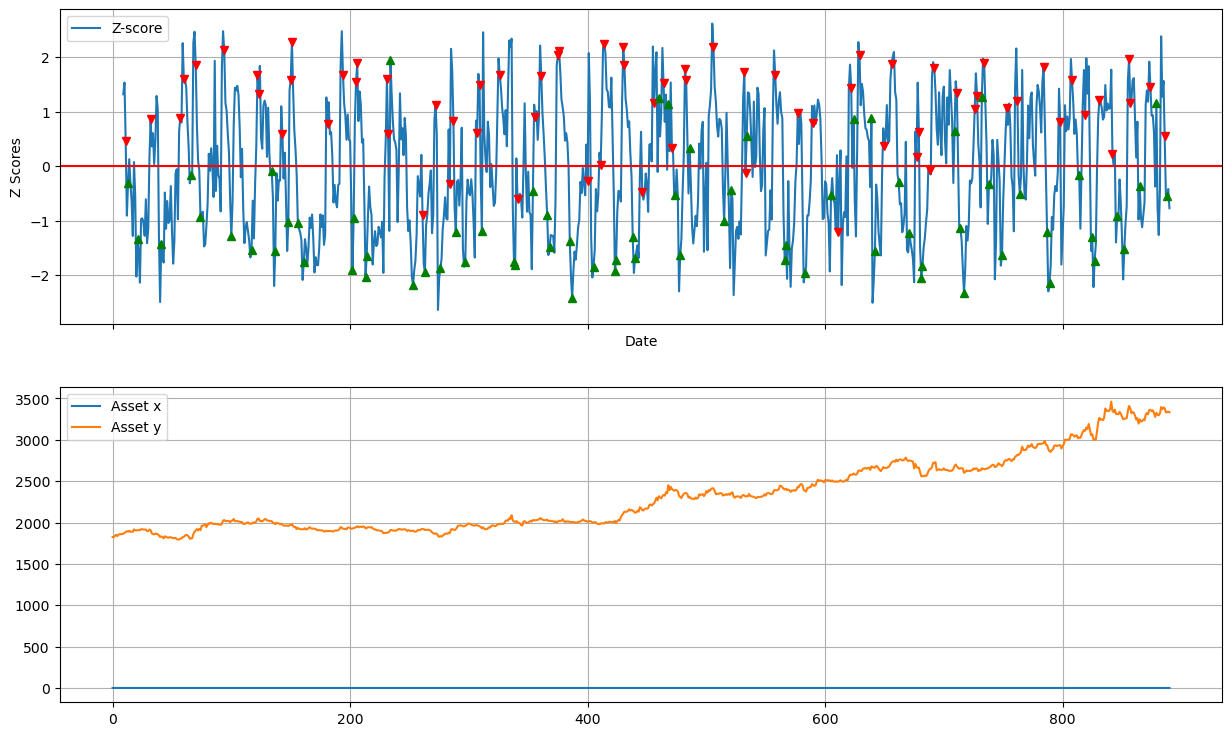

In [8]:
model = pair_trading(pair_portfolio[test_pair[0]], pair_portfolio[test_pair[1]], ZSCORE_ENTRY=1.5)
spread = model.compute_spread()
z_scores = model.compute_z_score(10)
df = model.generate_signals()
model.plot_signals(df)

In [47]:
model.computePnL(df)

,z_scores,z_signal,positions,BUY_or_SELL,x_pnl,y_pnl,cumulative_pnl
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.0,-0.000000,-0.00,0.000000
3,NaN,NaN,NaN,0.0,-0.000000,-0.00,0.000000
4,NaN,NaN,NaN,0.0,-0.000000,-0.00,0.000000
...,...,...,...,...,...,...,...
886,0.547424,NaN,-1.0,-1.0,656.637433,3381.55,6392.903010
887,-0.522336,NaN,0.0,0.0,-0.000000,-0.00,6392.903010
888,-0.556164,NaN,0.0,1.0,-660.227125,-3332.40,2400.275885
889,-0.420774,NaN,0.0,0.0,-0.000000,-0.00,2400.275885
